# Exploratory Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import math
from sklearn.ensemble import RandomForestClassifier


from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

# Reading Data

# Reading gene and Variants Data

In [3]:
data_variants = pd.read_csv('C:\\Users\\Khushmeet Singh\\Downloads\\training_variants')
print('Number of data points : ', data_variants.shape[0])
print('Number of features : ', data_variants.shape[1])
print('Features : ', data_variants.columns.values)
data_variants.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


# Reading Text Data

In [4]:
# note the seprator in this file
data_text =pd.read_csv("C:\\Users\\Khushmeet Singh\\Downloads\\training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# #Preprocessing

In [5]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [6]:
# Text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 47.28520687981337 seconds


In [7]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [10]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


# Train test split data

In [11]:
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')
y_true = result[['Class']]
x_true = result.drop(['Class'], axis=1)


print("Feature columns in dataset: ")
print(x_true.head())
print()
print("Target columns in dataset: ")
print(y_true.head())

Feature columns in dataset: 
   ID    Gene             Variation  \
0   0  FAM58A  Truncating_Mutations   
1   1     CBL                 W802*   
2   2     CBL                 Q249E   
3   3     CBL                 N454D   
4   4     CBL                 L399V   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...  

Target columns in dataset: 
   Class
0      1
1      2
2      2
3      3
4      4


In [12]:
# Split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
x_train, x_test, y_train, y_test = train_test_split(x_true, y_true, stratify=y_true, test_size=0.2)

# Split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

In [13]:
print('Number of data points in train data:', x_train.shape[0])
print('Number of data points in test data:', x_test.shape[0])
print('Number of data points in cross validation data:', x_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


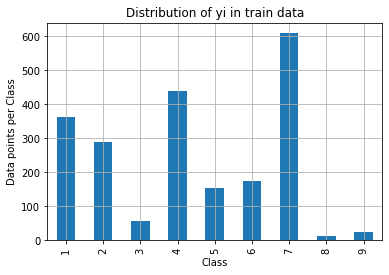

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


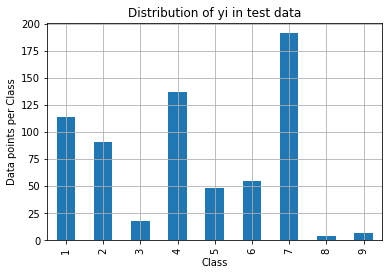

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


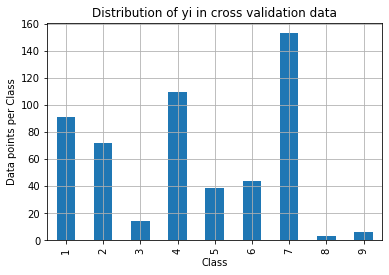

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [14]:
def plot_distribution(class_distribution,title,xlabel,ylabel):
    class_distribution.plot(kind='bar')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()


# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train['Class'].value_counts().sort_index()
test_class_distribution = y_test['Class'].value_counts().sort_index()
cv_class_distribution = y_cv['Class'].value_counts().sort_index()

plot_distribution(train_class_distribution,
                 'Distribution of yi in train data',
                 'Class',
                 'Data points per Class')

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], 
          '(', np.round((train_class_distribution.values[i]/x_train.shape[0]*100), 3), '%)')
    
print('-'*80)



plot_distribution(test_class_distribution,
                 'Distribution of yi in test data',
                 'Class',
                 'Data points per Class')

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(test_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], 
          '(', np.round((test_class_distribution.values[i]/x_test.shape[0]*100), 3), '%)')

print('-'*80)



plot_distribution(cv_class_distribution,
                 'Distribution of yi in cross validation data',
                 'Class',
                 'Data points per Class')

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(cv_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          '(', np.round((cv_class_distribution.values[i]/x_cv.shape[0]*100), 3), '%)')

# Prediction using Random Model

In [57]:
def plot_matrix(matrix,labels):
    plt.figure(figsize=(20,7))    
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    cm = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    recall_table =(((cm.T)/(cm.sum(axis=1))).T)
    # How did we calculateed recall_table :
    # divide each element of the confusion matrix with the sum of elements in that column    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    precision_table =(cm/cm.sum(axis=0))
    # How did we calculateed precision_table :
    # divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]    
    print()
    print("-"*20, "Confusion matrix", "-"*20)
    plot_matrix(cm,labels)

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plot_matrix(precision_table,labels)    
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plot_matrix(recall_table,labels)

Log loss on Cross Validation Data using Random Model 2.497792642083869
Log loss on Test Data using Random Model 2.472101948254495

-------------------- Confusion matrix --------------------


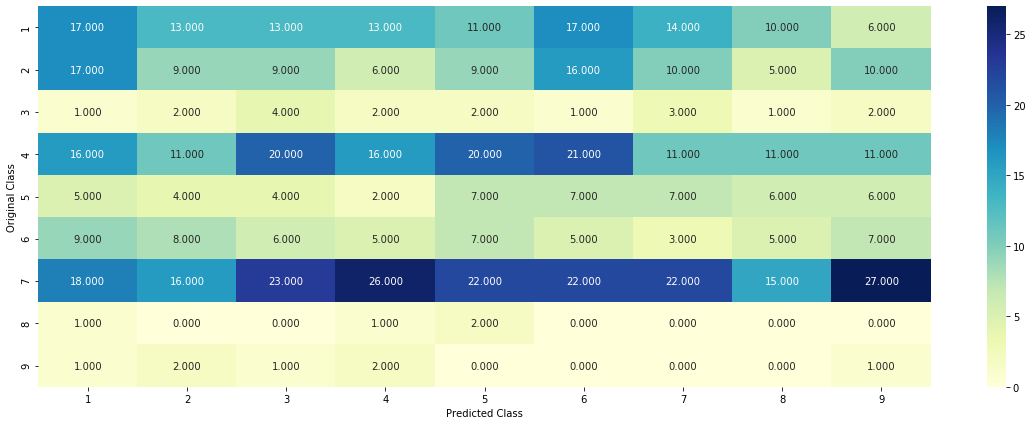

-------------------- Precision matrix (Columm Sum=1) --------------------


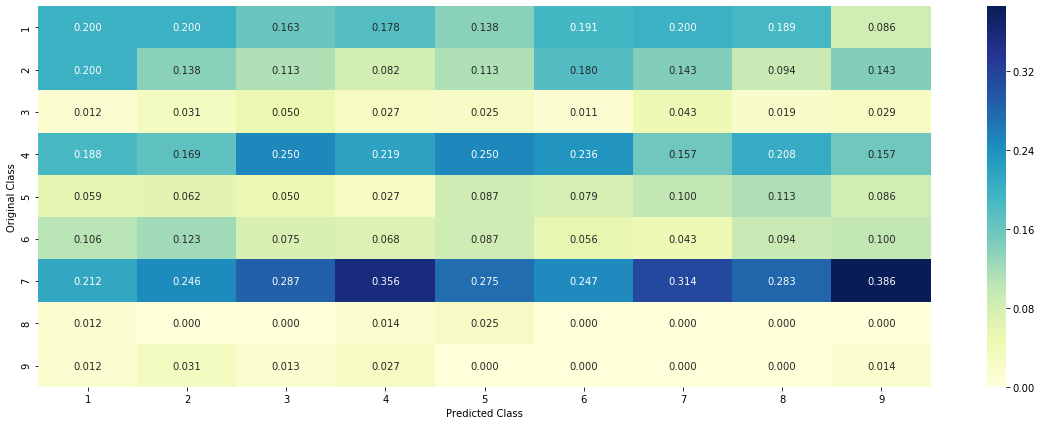

-------------------- Recall matrix (Row sum=1) --------------------


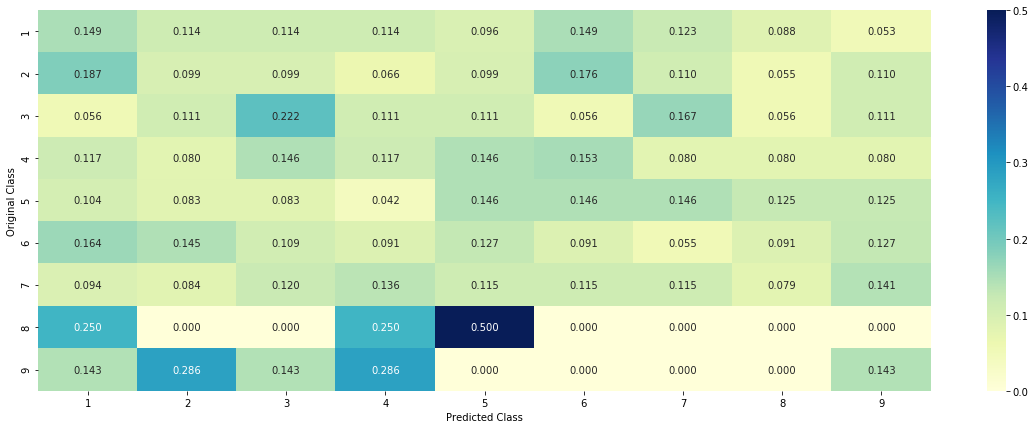

In [16]:
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = x_test.shape[0]
cv_data_len = x_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
# We create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

# Univariate Analysis 

In [17]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['x_train', 'x_test', 'x_cv']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = x_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = x_train.loc[(y_train['Class']==k) & (x_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = x_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [18]:
unique_genes = x_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 232
BRCA1     169
TP53      104
EGFR       84
BRCA2      83
PTEN       77
BRAF       60
KIT        59
ERBB2      47
PDGFRA     41
ALK        40
Name: Gene, dtype: int64


In [19]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 232 different categories of genes in the train data, and they are distibuted as follows


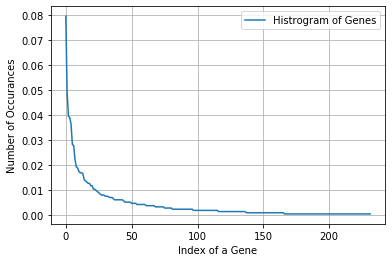

In [20]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

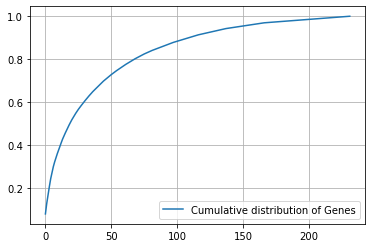

In [21]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [22]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [26]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [27]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])


In [28]:
train_gene_feature_onehotCoding

<2124x236 sparse matrix of type '<class 'numpy.float64'>'
	with 2124 stored elements in Compressed Sparse Row format>

In [29]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", 
      train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 236)


For values of alpha =  1e-05 The log loss is: 1.1797694412356643
For values of alpha =  0.0001 The log loss is: 1.155621785595475
For values of alpha =  0.001 The log loss is: 1.185846909120284
For values of alpha =  0.01 The log loss is: 1.2937854756949845
For values of alpha =  0.1 The log loss is: 1.4063938697951321
For values of alpha =  1 The log loss is: 1.4511312472038138


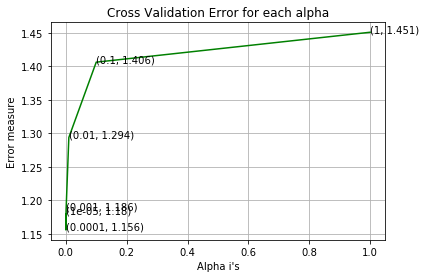

For values of best alpha =  0.0001 The train log loss is: 1.014604830453934
For values of best alpha =  0.0001 The cross validation log loss is: 1.155621785595475
For values of best alpha =  0.0001 The test log loss is: 1.1818342257320826


In [30]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [31]:
print("Q6. How many data points in Test and CV datasets are covered by the ", 
      unique_genes.shape[0], " genes in train dataset?")

test_coverage=x_test[x_test['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
cv_coverage=x_cv[x_cv['Gene'].isin(list(set(x_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 641 out of 665 : 96.39097744360903
2. In cross validation data 521 out of  532 : 97.93233082706767


In [32]:
unique_variations = x_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1928
Truncating_Mutations    63
Amplification           49
Deletion                47
Fusions                 17
Overexpression           6
G12V                     4
E17K                     3
ETV6-NTRK3_Fusion        2
S308A                    2
Q61H                     2
Name: Variation, dtype: int64


In [33]:
print("Ans: There are", unique_variations.shape[0] ,
      "different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1928 different categories of variations in the train data, and they are distibuted as follows


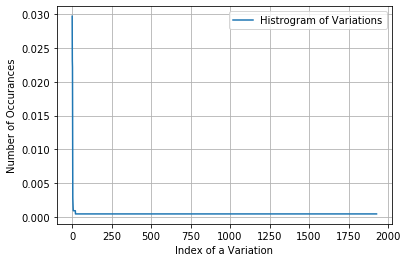

In [34]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02966102 0.0527307  0.07485876 ... 0.99905838 0.99952919 1.        ]


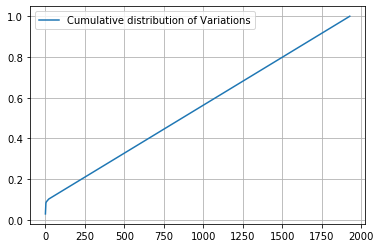

In [35]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [36]:
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))

# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_test))

# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [37]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", 
      train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [38]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

In [39]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", 
      train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1961)


For values of alpha =  1e-05 The log loss is: 1.734376903289353
For values of alpha =  0.0001 The log loss is: 1.7259746698767122
For values of alpha =  0.001 The log loss is: 1.7292469555718046
For values of alpha =  0.01 The log loss is: 1.734075581840475
For values of alpha =  0.1 The log loss is: 1.7433309221788011
For values of alpha =  1 The log loss is: 1.7446894243597695


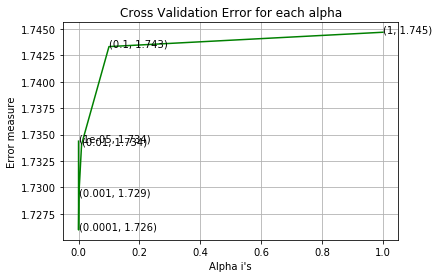

For values of best alpha =  0.0001 The train log loss is: 0.7511696453332067
For values of best alpha =  0.0001 The cross validation log loss is: 1.7259746698767122
For values of best alpha =  0.0001 The test log loss is: 1.6827263182540182


In [40]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [41]:
print("Q12. How many data points are covered by total ", 
      unique_variations.shape[0], 
      " genes in test and cross validation data sets?")
test_coverage=x_test[x_test['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
cv_coverage=x_cv[x_cv['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Q12. How many data points are covered by total  1928  genes in test and cross validation data sets?
Ans
1. In test data 82 out of 665 : 12.330827067669173
2. In cross validation data 44 out of  532 : 8.270676691729323


In [45]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [46]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [47]:
x_train['TEXT'].head()

2946    abstract case 84 year old woman diagnosed stag...
1849    introduction ctcf originally identified zf 3 p...
2267    pten phosphatase tensin homolog phosphatase un...
2660    mutations brca1 brca2 account majority heredit...
2176    phosphatase tensin homolog pten inactivating m...
Name: TEXT, dtype: object

In [48]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, min_tfidf=0.1, grp_ids=None, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [46]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['TEXT'])

# getting top 1000 feature names (words)
train_text_features = top_mean_feats(train_text_feature_onehotCoding,
                                                text_vectorizer.get_feature_names(),
                                                top_n=1000)['feature'].tolist()


In [47]:
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
train_text_fea_counts

array([9.16453893, 8.84428113, 0.03207983, ..., 0.02137892, 0.0252473 ,
       0.04781381])

In [48]:
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [49]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[y_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(x_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [50]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

In [51]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [52]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [53]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [54]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({0.0218755337978128: 28, 0.08321330026799921: 16, 0.026246636383422933: 12, 0.03145946494793289: 9, 0.02008233341412003: 8, 0.2437365183161721: 7, 0.02011579759256247: 7, 0.32861753250452697: 6, 0.0386363309935239: 6, 0.022546512549612794: 5, 0.06291892989586578: 4, 0.015370571147195871: 4, 0.0887160069489253: 3, 0.07451658762836698: 3, 0.02781312058705004: 3, 0.019979238214001684: 3, 0.01844305136135315: 3, 0.018410686629147566: 3, 0.015297310298719644: 3, 0.011549291101875801: 3, 0.1537777084761026: 2, 0.09437839484379865: 2, 0.06454052529505916: 2, 0.06283334985894277: 2, 0.060133265939140645: 2, 0.05237655967454377: 2, 0.04935636058403267: 2, 0.048303138326722214: 2, 0.043713637180042716: 2, 0.04016466682824006: 2, 0.03692783406253373: 2, 0.03596656924259874: 2, 0.02636464513067374: 2, 0.023707986130952194: 2, 0.022705613937073377: 2, 0.02211812559425675: 2, 0.021164474578780082: 2, 0.021128150160064973: 2, 0.0202627207542918: 2, 0.01854520627260063: 2, 0.01642455999414605:

For values of alpha =  1e-05 The log loss is: 1.2874760994060528
For values of alpha =  0.0001 The log loss is: 1.1576333991816496
For values of alpha =  0.001 The log loss is: 1.1598307015096385
For values of alpha =  0.01 The log loss is: 1.2175346271743057
For values of alpha =  0.1 The log loss is: 1.2994051256827142
For values of alpha =  1 The log loss is: 1.5350983698530376


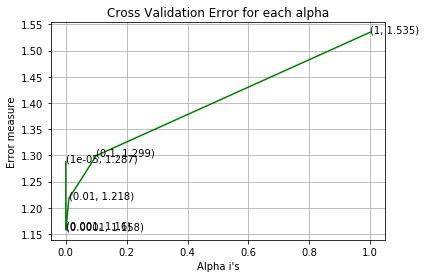

For values of best alpha =  0.0001 The train log loss is: 0.6644156062524178
For values of best alpha =  0.0001 The cross validation log loss is: 1.1576333991816496
For values of best alpha =  0.0001 The test log loss is: 1.0495859922955166


In [55]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [56]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])   
    
    df_text_features = top_mean_feats(df_text_fea,
                                      df_text_vec.get_feature_names(),
                                      top_n=1000)['feature'].tolist()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [57]:
len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(x_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

62.1 % of word of test data appeared in train data
58.7 % of word of Cross Validation appeared in train data


# Machine Learning Models

In [59]:
#Data preparation for ML models.

#Misc. functionns for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [59]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [60]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(x_train['Gene'])
    var_vec  = var_count_vec.fit(x_train['Variation'])
    text_vec = text_count_vec.fit(x_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:            
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")


In [61]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(y_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [62]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55006)
(number of data points * number of features) in test data =  (665, 55006)
(number of data points * number of features) in cross validation data = (532, 55006)


In [63]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# BaseLine Model(Naive Bayes)

for alpha = 1e-05
Log Loss : 1.3102155807905453
for alpha = 0.0001
Log Loss : 1.3010604173831077
for alpha = 0.001
Log Loss : 1.3011148791442082
for alpha = 0.1
Log Loss : 1.2955981289530853
for alpha = 1
Log Loss : 1.2547428785482246
for alpha = 10
Log Loss : 1.3314835325730479
for alpha = 100
Log Loss : 1.2443518921483896
for alpha = 1000
Log Loss : 1.221568175176729


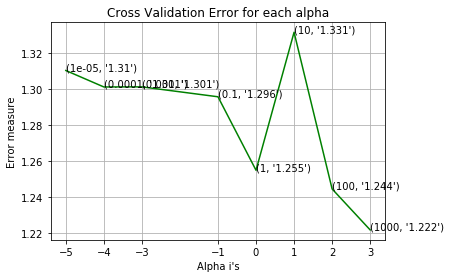

For values of best alpha =  1000 The train log loss is: 0.9395398613587067
For values of best alpha =  1000 The cross validation log loss is: 1.221568175176729
For values of best alpha =  1000 The test log loss is: 1.189010329869463


In [64]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss : 1.221568175176729
Number of missclassified point : 0.40601503759398494

-------------------- Confusion matrix --------------------


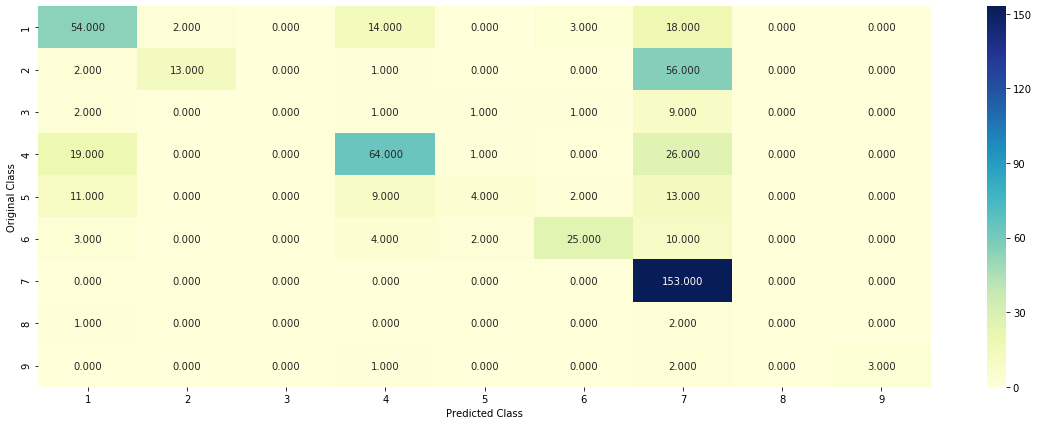

-------------------- Precision matrix (Columm Sum=1) --------------------


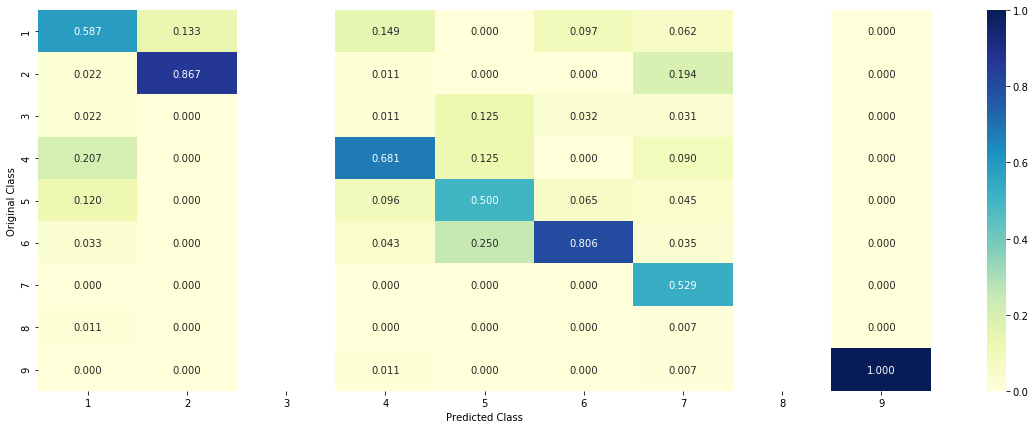

-------------------- Recall matrix (Row sum=1) --------------------


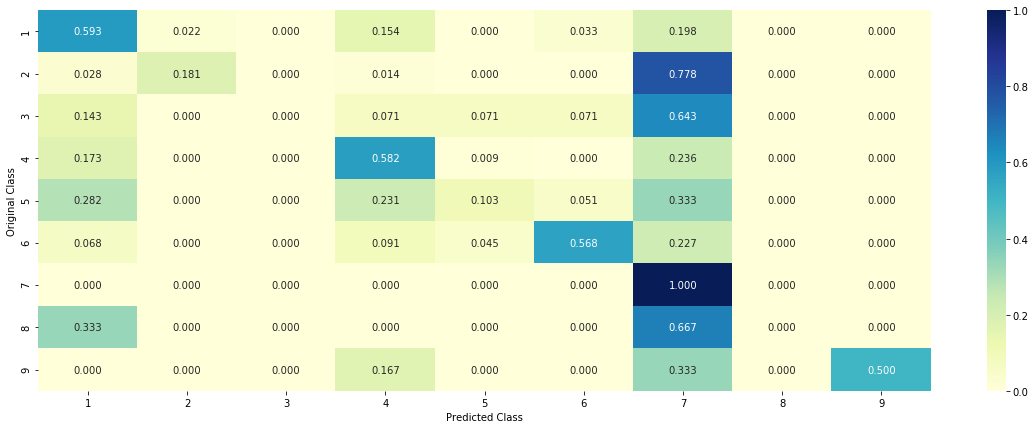

In [65]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [66]:
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6539 0.0204 0.0011 0.2357 0.0137 0.0155 0.059  0.0007 0.    ]]
Actual Class : 1
--------------------------------------------------
9 Text feature [protein] present in test data point [True]
10 Text feature [type] present in test data point [True]
13 Text feature [wild] present in test data point [True]
14 Text feature [dna] present in test data point [True]
15 Text feature [one] present in test data point [True]
16 Text feature [therefore] present in test data point [True]
17 Text feature [affect] present in test data point [True]
18 Text feature [results] present in test data point [True]
19 Text feature [two] present in test data point [True]
20 Text feature [binding] present in test data point [True]
21 Text feature [using] present in test data point [True]
22 Text feature [functions] present in test data point [True]
23 Text feature [containing] present in test data point [True]
24 Text feature [either] present in test data poi

165 Text feature [identified] present in test data point [True]
166 Text feature [genetic] present in test data point [True]
167 Text feature [mutant] present in test data point [True]
168 Text feature [additional] present in test data point [True]
169 Text feature [interact] present in test data point [True]
170 Text feature [bind] present in test data point [True]
171 Text feature [sites] present in test data point [True]
172 Text feature [sufficient] present in test data point [True]
173 Text feature [changes] present in test data point [True]
174 Text feature [single] present in test data point [True]
175 Text feature [central] present in test data point [True]
176 Text feature [among] present in test data point [True]
178 Text feature [figure] present in test data point [True]
179 Text feature [complete] present in test data point [True]
180 Text feature [significantly] present in test data point [True]
181 Text feature [acid] present in test data point [True]
183 Text feature [se

364 Text feature [broad] present in test data point [True]
365 Text feature [28] present in test data point [True]
366 Text feature [modulate] present in test data point [True]
367 Text feature [sequencing] present in test data point [True]
368 Text feature [roles] present in test data point [True]
369 Text feature [destabilized] present in test data point [True]
370 Text feature [observation] present in test data point [True]
371 Text feature [represents] present in test data point [True]
372 Text feature [activities] present in test data point [True]
373 Text feature [examined] present in test data point [True]
376 Text feature [fail] present in test data point [True]
378 Text feature [often] present in test data point [True]
379 Text feature [13] present in test data point [True]
380 Text feature [decreased] present in test data point [True]
381 Text feature [plasmid] present in test data point [True]
382 Text feature [underlying] present in test data point [True]
384 Text feature [

611 Text feature [05] present in test data point [True]
612 Text feature [interfere] present in test data point [True]
613 Text feature [far] present in test data point [True]
614 Text feature [reduction] present in test data point [True]
616 Text feature [residue] present in test data point [True]
617 Text feature [groups] present in test data point [True]
618 Text feature [much] present in test data point [True]
619 Text feature [lysate] present in test data point [True]
620 Text feature [demonstrated] present in test data point [True]
623 Text feature [recent] present in test data point [True]
627 Text feature [hypothesis] present in test data point [True]
629 Text feature [powerpoint] present in test data point [True]
632 Text feature [factors] present in test data point [True]
634 Text feature [apoptosis] present in test data point [True]
635 Text feature [hundred] present in test data point [True]
636 Text feature [quantitative] present in test data point [True]
651 Text feature 

913 Text feature [staining] present in test data point [True]
915 Text feature [antibodies] present in test data point [True]
917 Text feature [43] present in test data point [True]
918 Text feature [implications] present in test data point [True]
919 Text feature [cycle] present in test data point [True]
921 Text feature [activation] present in test data point [True]
922 Text feature [bears] present in test data point [True]
923 Text feature [per] present in test data point [True]
927 Text feature [induction] present in test data point [True]
930 Text feature [use] present in test data point [True]
933 Text feature [requires] present in test data point [True]
937 Text feature [seen] present in test data point [True]
940 Text feature [average] present in test data point [True]
943 Text feature [proteolysis] present in test data point [True]
944 Text feature [dimensional] present in test data point [True]
950 Text feature [encodes] present in test data point [True]
953 Text feature [int

In [67]:
test_point_index = 55
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0142 0.0244 0.0058 0.0115 0.0217 0.0158 0.9031 0.0025 0.0011]]
Actual Class : 7
--------------------------------------------------
15 Text feature [cells] present in test data point [True]
16 Text feature [downstream] present in test data point [True]
17 Text feature [activated] present in test data point [True]
19 Text feature [cell] present in test data point [True]
21 Text feature [contrast] present in test data point [True]
22 Text feature [activation] present in test data point [True]
23 Text feature [presence] present in test data point [True]
24 Text feature [shown] present in test data point [True]
25 Text feature [expressing] present in test data point [True]
26 Text feature [factor] present in test data point [True]
27 Text feature [also] present in test data point [True]
28 Text feature [phosphorylation] present in test data point [True]
29 Text feature [growth] present in test data point [True]
30 Text feature [inhibito

170 Text feature [overexpression] present in test data point [True]
171 Text feature [clinical] present in test data point [True]
172 Text feature [pathway] present in test data point [True]
174 Text feature [similarly] present in test data point [True]
175 Text feature [show] present in test data point [True]
176 Text feature [time] present in test data point [True]
177 Text feature [whereas] present in test data point [True]
178 Text feature [express] present in test data point [True]
179 Text feature [additional] present in test data point [True]
180 Text feature [drug] present in test data point [True]
181 Text feature [vitro] present in test data point [True]
182 Text feature [specific] present in test data point [True]
183 Text feature [trials] present in test data point [True]
184 Text feature [promote] present in test data point [True]
186 Text feature [positive] present in test data point [True]
187 Text feature [measured] present in test data point [True]
189 Text feature [18

379 Text feature [14] present in test data point [True]
381 Text feature [oncogene] present in test data point [True]
383 Text feature [identify] present in test data point [True]
384 Text feature [increasing] present in test data point [True]
389 Text feature [used] present in test data point [True]
393 Text feature [subjected] present in test data point [True]
395 Text feature [40] present in test data point [True]
397 Text feature [introduction] present in test data point [True]
401 Text feature [driven] present in test data point [True]
404 Text feature [importance] present in test data point [True]
406 Text feature [low] present in test data point [True]
407 Text feature [22] present in test data point [True]
408 Text feature [50] present in test data point [True]
410 Text feature [rate] present in test data point [True]
412 Text feature [factors] present in test data point [True]
414 Text feature [variety] present in test data point [True]
417 Text feature [along] present in test

631 Text feature [like] present in test data point [True]
633 Text feature [vectors] present in test data point [True]
636 Text feature [extracted] present in test data point [True]
637 Text feature [direct] present in test data point [True]
639 Text feature [33] present in test data point [True]
641 Text feature [thereby] present in test data point [True]
643 Text feature [inhibitory] present in test data point [True]
646 Text feature [review] present in test data point [True]
647 Text feature [exon] present in test data point [True]
648 Text feature [majority] present in test data point [True]
651 Text feature [viability] present in test data point [True]
652 Text feature [preclinical] present in test data point [True]
656 Text feature [metastatic] present in test data point [True]
660 Text feature [vivo] present in test data point [True]
663 Text feature [additionally] present in test data point [True]
664 Text feature [future] present in test data point [True]
666 Text feature [lea

927 Text feature [deletion] present in test data point [True]
928 Text feature [repeated] present in test data point [True]
931 Text feature [confers] present in test data point [True]
934 Text feature [biology] present in test data point [True]
936 Text feature [methods] present in test data point [True]
939 Text feature [markedly] present in test data point [True]
942 Text feature [underlying] present in test data point [True]
949 Text feature [synthesized] present in test data point [True]
950 Text feature [therapeutics] present in test data point [True]
951 Text feature [roles] present in test data point [True]
955 Text feature [05] present in test data point [True]
956 Text feature [molecules] present in test data point [True]
957 Text feature [causes] present in test data point [True]
964 Text feature [provides] present in test data point [True]
966 Text feature [site] present in test data point [True]
968 Text feature [preferentially] present in test data point [True]
970 Text f

# KNN Model

for alpha = 5
Log Loss : 1.143315403858183
for alpha = 11
Log Loss : 1.0748031716504756
for alpha = 15
Log Loss : 1.068635924092476
for alpha = 21
Log Loss : 1.067819110078448
for alpha = 31
Log Loss : 1.0601802267389477
for alpha = 41
Log Loss : 1.0525983320073617
for alpha = 51
Log Loss : 1.05114447442798
for alpha = 99
Log Loss : 1.0628356617640367


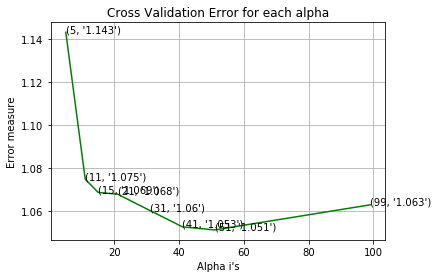

For values of best alpha =  51 The train log loss is: 0.8972936640409283
For values of best alpha =  51 The cross validation log loss is: 1.05114447442798
For values of best alpha =  51 The test log loss is: 1.0395637894469603


In [68]:
# find more about KNeighborsClassifier() 
# here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_,eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.05114447442798
Number of mis-classified points : 0.36466165413533835

-------------------- Confusion matrix --------------------


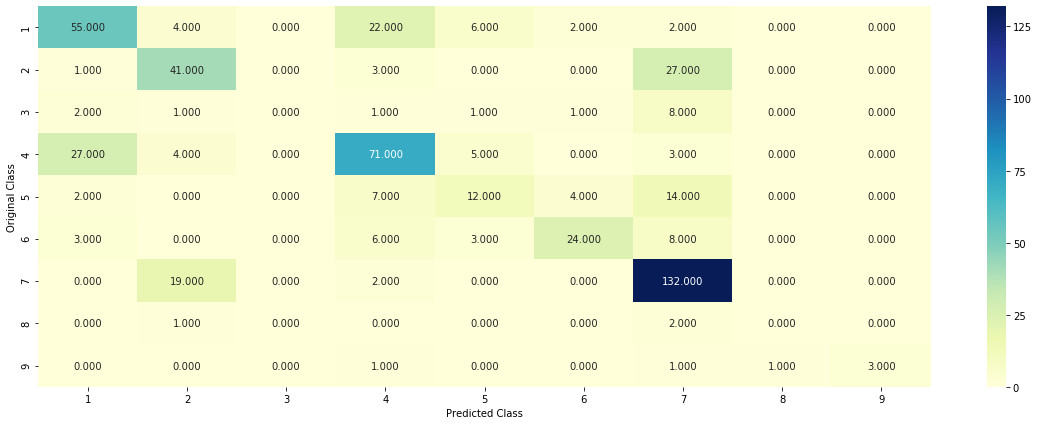

-------------------- Precision matrix (Columm Sum=1) --------------------


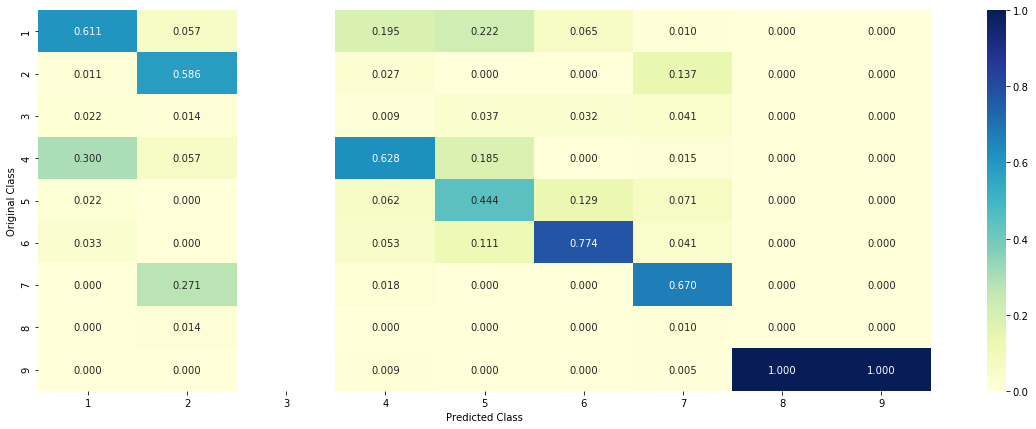

-------------------- Recall matrix (Row sum=1) --------------------


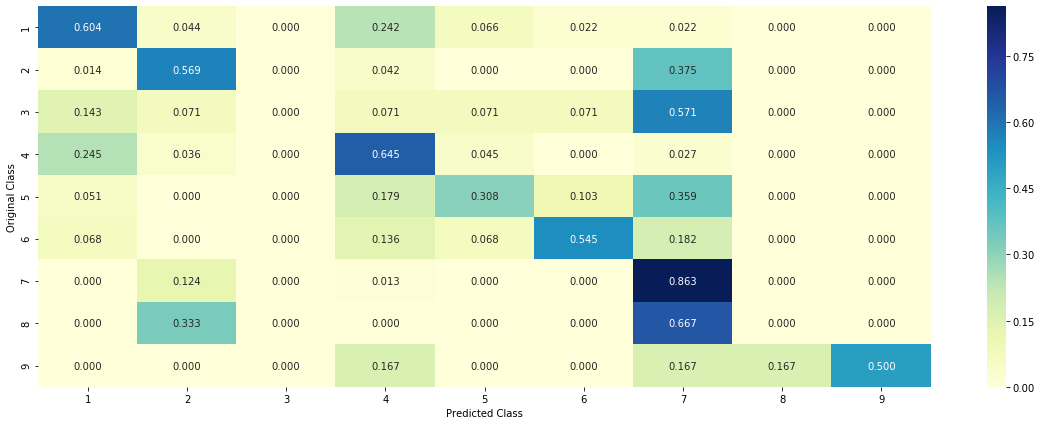

In [69]:
# find more about KNeighborsClassifier() 
# here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [70]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
The  51  nearest neighbours of the test points belongs to classes [1 1 4 1 1 1 1 1 1 1 4 6 1 1 2 6 1 1 1 4 1 1 1 1 1 4 4 1 4 4 1 4 1 1 1 1 4
 5 1 4 1 5 1 1 4 1 1 4 4 4 4]
Fequency of nearest points : Counter({1: 31, 4: 15, 6: 2, 5: 2, 2: 1})


In [71]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 51 and the nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 4 4 4 4 1 1 4 4 4 4 1 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Fequency of nearest points : Counter({4: 47, 1: 4})


# Logistic Regression

for alpha = 1e-06
Log Loss : 1.3564523765925833
for alpha = 1e-05
Log Loss : 1.3108055239663265
for alpha = 0.0001
Log Loss : 1.1254493920067241
for alpha = 0.001
Log Loss : 1.1116768856075288
for alpha = 0.01
Log Loss : 1.1516152184972408
for alpha = 0.1
Log Loss : 1.2572363740930683
for alpha = 1
Log Loss : 1.4807968868899772
for alpha = 10
Log Loss : 1.5176515480817374
for alpha = 100
Log Loss : 1.5215916360402555


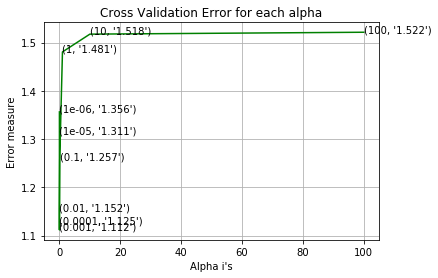

For values of best alpha =  0.001 The train log loss is: 0.5353964942439243
For values of best alpha =  0.001 The cross validation log loss is: 1.1116768856075288
For values of best alpha =  0.001 The test log loss is: 0.9771005085130103


In [72]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1116768856075288
Number of mis-classified points : 0.3458646616541353

-------------------- Confusion matrix --------------------


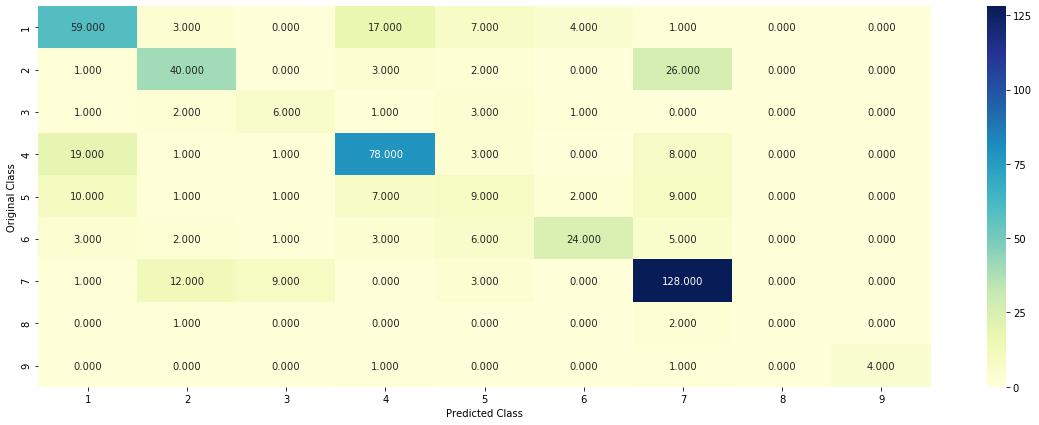

-------------------- Precision matrix (Columm Sum=1) --------------------


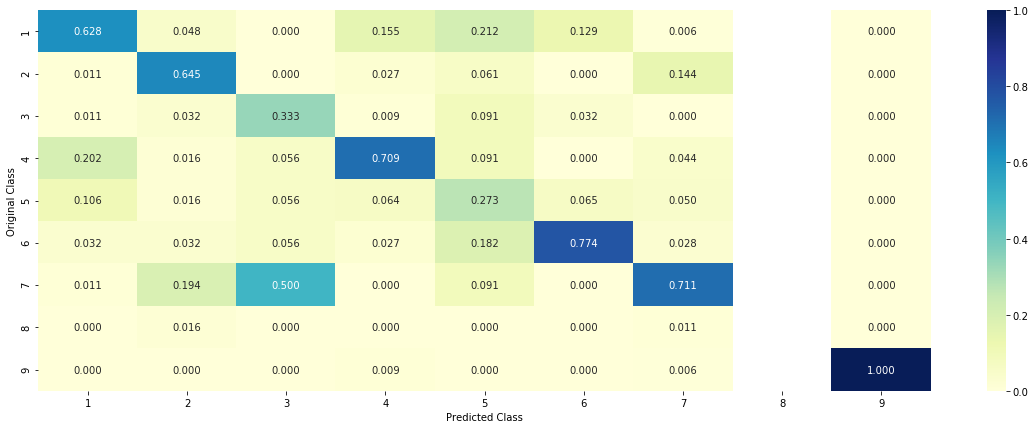

-------------------- Recall matrix (Row sum=1) --------------------


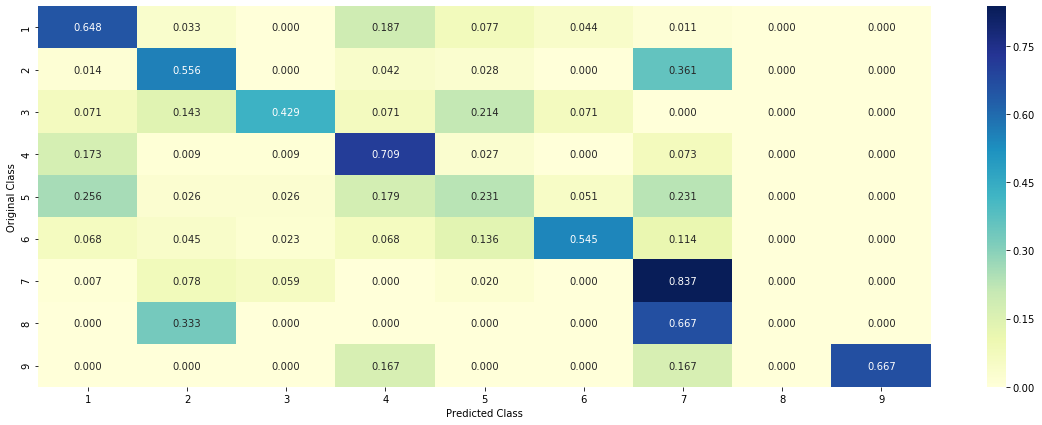

In [73]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [74]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [75]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6416 0.0674 0.0016 0.1509 0.0155 0.1025 0.0145 0.0037 0.0024]]
Actual Class : 1
--------------------------------------------------
249 Text feature [immobilized] present in test data point [True]
289 Text feature [aggregation] present in test data point [True]
423 Text feature [synergy] present in test data point [True]
483 Text feature [aggregate] present in test data point [True]
513 Text feature [gal] present in test data point [True]
560 Text feature [destabilized] present in test data point [True]
613 Text feature [fas] present in test data point [True]
691 Text feature [saos] present in test data point [True]
712 Text feature [aggregates] present in test data point [True]
780 Text feature [deficient] present in test data point [True]
836 Text feature [unfolded] present in test data point [True]
958 Text feature [tetramerization] present in test data point [True]
973 Text feature [r282] present in test data point [True]
975 Te

In [76]:
test_point_index = 55
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0043 0.0213 0.0012 0.0041 0.0058 0.0027 0.9569 0.0021 0.0017]]
Actual Class : 7
--------------------------------------------------
21 Text feature [constitutive] present in test data point [True]
33 Text feature [doublet] present in test data point [True]
37 Text feature [downstream] present in test data point [True]
41 Text feature [activated] present in test data point [True]
66 Text feature [oncogene] present in test data point [True]
71 Text feature [constitutively] present in test data point [True]
104 Text feature [overexpression] present in test data point [True]
129 Text feature [activation] present in test data point [True]
154 Text feature [papillary] present in test data point [True]
182 Text feature [proliferate] present in test data point [True]
200 Text feature [cap] present in test data point [True]
235 Text feature [adenocarcinoma] present in test data point [True]
236 Text feature [expressing] present in test data 

for alpha = 1e-06
Log Loss : 1.3150491995633427
for alpha = 1e-05
Log Loss : 1.280635740646622
for alpha = 0.0001
Log Loss : 1.1385262297972858
for alpha = 0.001
Log Loss : 1.1148520648245654
for alpha = 0.01
Log Loss : 1.1628632235687217
for alpha = 0.1
Log Loss : 1.2172747068611212
for alpha = 1
Log Loss : 1.4346594882701027


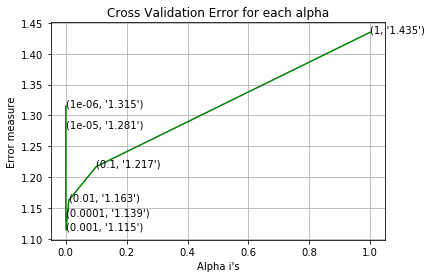

For values of best alpha =  0.001 The train log loss is: 0.5346832885161039
For values of best alpha =  0.001 The cross validation log loss is: 1.1148520648245654
For values of best alpha =  0.001 The test log loss is: 0.985931777777684


In [77]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1148520648245654
Number of mis-classified points : 0.34022556390977443

-------------------- Confusion matrix --------------------


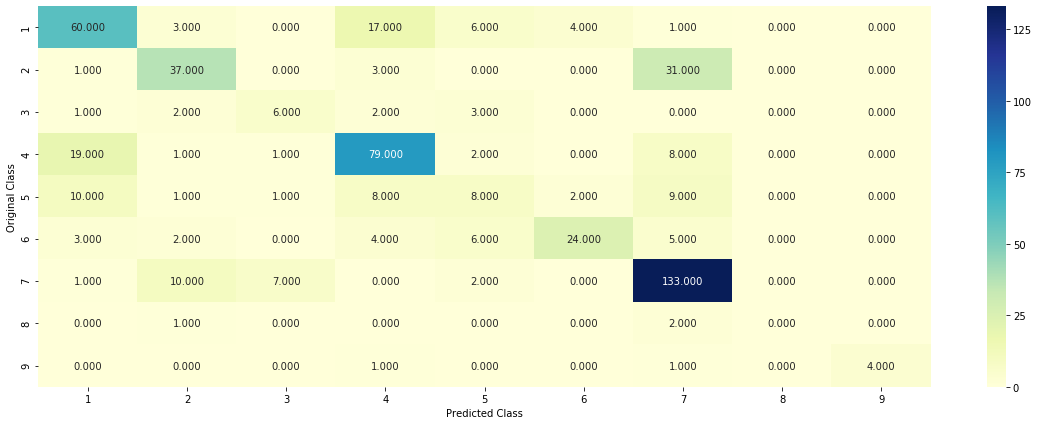

-------------------- Precision matrix (Columm Sum=1) --------------------


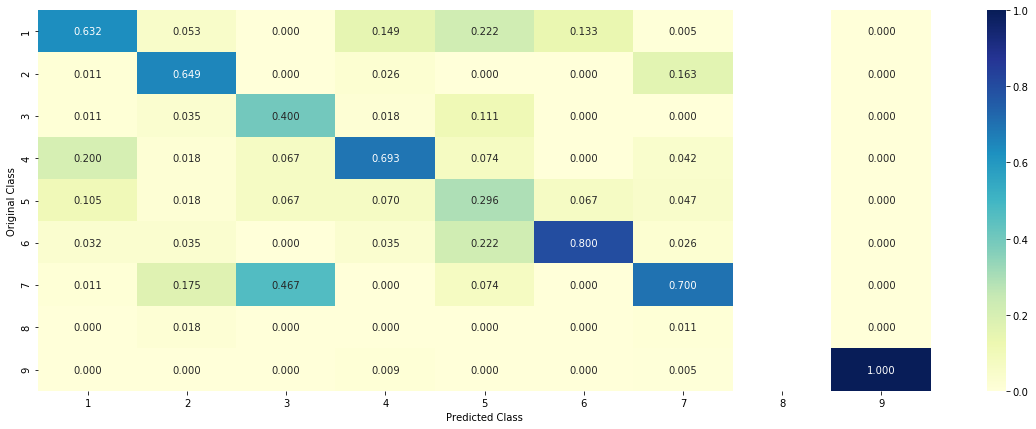

-------------------- Recall matrix (Row sum=1) --------------------


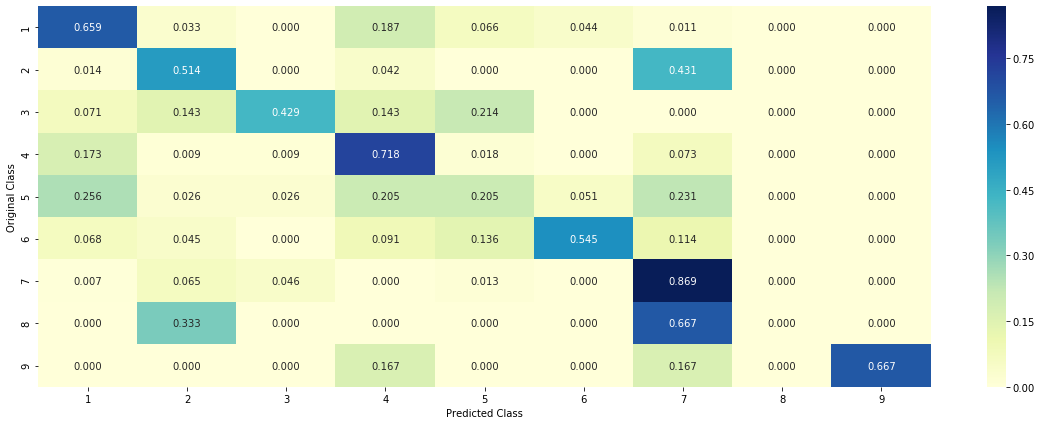

In [78]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [79]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index],
                     no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0533 0.037  0.0023 0.7504 0.0129 0.0065 0.1332 0.0031 0.0013]]
Actual Class : 4
--------------------------------------------------
119 Text feature [suppressor] present in test data point [True]
130 Text feature [devoid] present in test data point [True]
167 Text feature [shen] present in test data point [True]
191 Text feature [ovary] present in test data point [True]
312 Text feature [mgcl] present in test data point [True]
405 Text feature [germline] present in test data point [True]
427 Text feature [nonidet] present in test data point [True]
431 Text feature [eb1] present in test data point [True]
433 Text feature [bsteii] present in test data point [True]
472 Text feature [tgf] present in test data point [True]
475 Text feature [asymmetric] present in test data point [True]
501 Text feature [phosphatases] present in test data point [True]
502 Text feature [tagged] present in test data point [True]
507 Text feature [localizati

In [80]:
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index],
                     no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[6.622e-01 5.980e-02 7.000e-04 1.696e-01 1.230e-02 7.600e-02 1.690e-02
  2.100e-03 4.000e-04]]
Actual Class : 1
--------------------------------------------------
237 Text feature [immobilized] present in test data point [True]
317 Text feature [aggregation] present in test data point [True]
386 Text feature [synergy] present in test data point [True]
494 Text feature [gal] present in test data point [True]
524 Text feature [aggregate] present in test data point [True]
560 Text feature [fas] present in test data point [True]
614 Text feature [destabilized] present in test data point [True]
698 Text feature [saos] present in test data point [True]
753 Text feature [deficient] present in test data point [True]
758 Text feature [aggregates] present in test data point [True]
808 Text feature [lysate] present in test data point [True]
876 Text feature [fail] present in test data point [True]
877 Text feature [unfolded] present in test data

# Linear Support Vector Machine

for C = 1e-05
Log Loss : 1.3358237402874038
for C = 0.0001
Log Loss : 1.2459074882326469
for C = 0.001
Log Loss : 1.1415185478977379
for C = 0.01
Log Loss : 1.1658462928531612
for C = 0.1
Log Loss : 1.3057530723351634
for C = 1
Log Loss : 1.5226488626928387
for C = 10
Log Loss : 1.5222364199812715
for C = 100
Log Loss : 1.5222364511280635


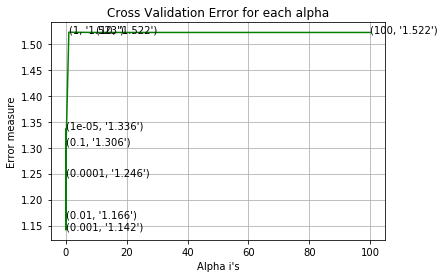

For values of best alpha =  0.001 The train log loss is: 0.5825419176978665
For values of best alpha =  0.001 The cross validation log loss is: 1.1415185478977379
For values of best alpha =  0.001 The test log loss is: 1.0158806372000406


In [81]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1415185478977379
Number of mis-classified points : 0.3458646616541353

-------------------- Confusion matrix --------------------


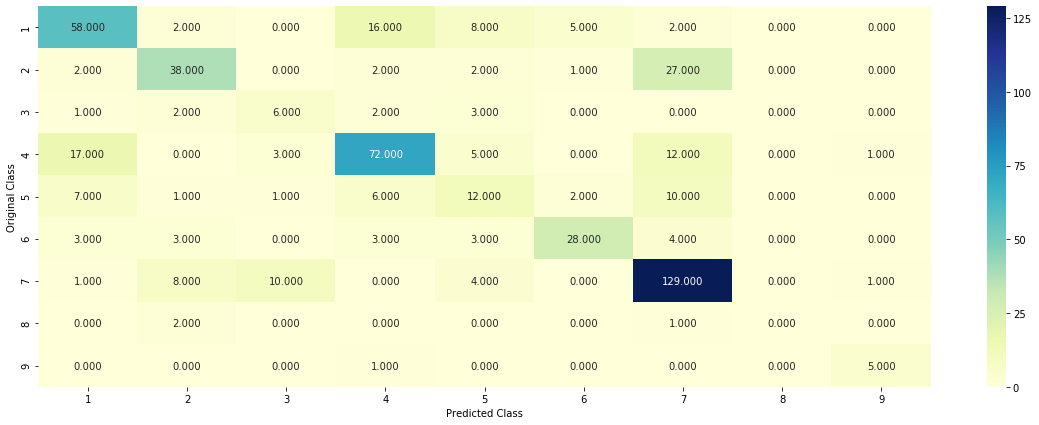

-------------------- Precision matrix (Columm Sum=1) --------------------


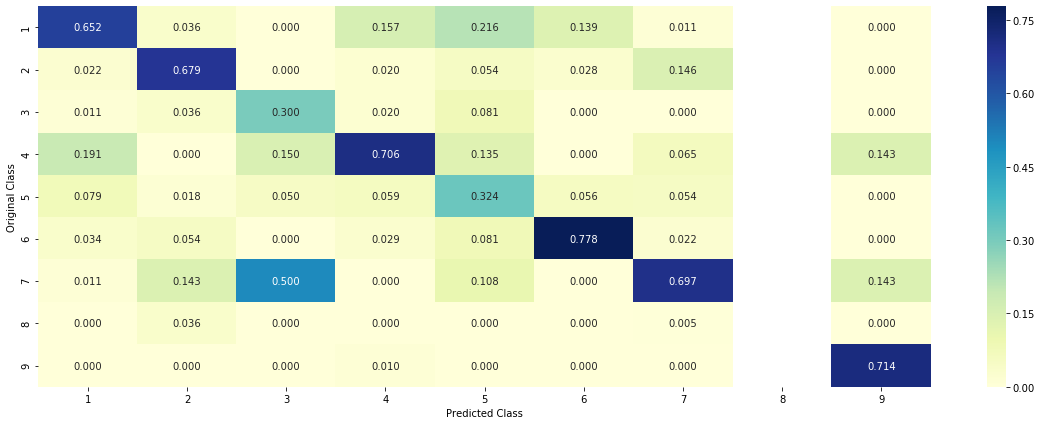

-------------------- Recall matrix (Row sum=1) --------------------


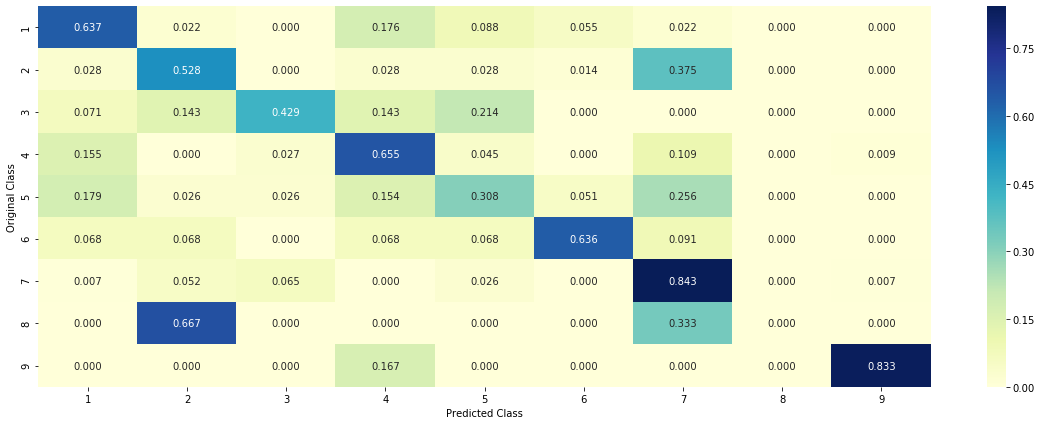

In [82]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [83]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index],
                     no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.3312 0.1303 0.0108 0.1193 0.0408 0.2191 0.1314 0.0052 0.0119]]
Actual Class : 1
--------------------------------------------------
392 Text feature [cancerous] present in test data point [True]
394 Text feature [aggregation] present in test data point [True]
404 Text feature [fas] present in test data point [True]
408 Text feature [immobilized] present in test data point [True]
462 Text feature [synergy] present in test data point [True]
536 Text feature [gal] present in test data point [True]
571 Text feature [lysate] present in test data point [True]
573 Text feature [germ] present in test data point [True]
716 Text feature [aggregates] present in test data point [True]
781 Text feature [fail] present in test data point [True]
842 Text feature [aggregate] present in test data point [True]
911 Text feature [feasibility] present in test data point [True]
941 Text feature [destabilized] present in test data point [True]
986 Text fea

In [85]:
test_point_index = 55
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0142 0.0597 0.0065 0.0326 0.0149 0.0036 0.8618 0.0024 0.0044]]
Actual Class : 7
--------------------------------------------------
195 Text feature [mir] present in test data point [True]
213 Text feature [constitutive] present in test data point [True]
246 Text feature [topical] present in test data point [True]
260 Text feature [oncogene] present in test data point [True]
273 Text feature [downstream] present in test data point [True]
278 Text feature [doublet] present in test data point [True]
288 Text feature [constitutively] present in test data point [True]
311 Text feature [activated] present in test data point [True]
348 Text feature [overexpression] present in test data point [True]
421 Text feature [expressing] present in test data point [True]
445 Text feature [kreb] present in test data point [True]
481 Text feature [adenocarcinoma] present in test data point [True]
498 Text feature [activation] present in test data poi

# Random Forest Classifier

In [86]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.239319569407836
for n_estimators = 100 and max depth =  10
Log Loss : 1.17375183690259
for n_estimators = 200 and max depth =  5
Log Loss : 1.2257761185916058
for n_estimators = 200 and max depth =  10
Log Loss : 1.1683034288206005
for n_estimators = 500 and max depth =  5
Log Loss : 1.2217249673939707
for n_estimators = 500 and max depth =  10
Log Loss : 1.166330073803563
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2112895823718948
for n_estimators = 1000 and max depth =  10
Log Loss : 1.164698704776365
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2093849266147776
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1642484433800526
For values of best estimator =  2000 The train log loss is: 0.6651723996745306
For values of best estimator =  2000 The cross validation log loss is: 1.1642484433800528
For values of best estimator =  2000 The test log loss is: 1.1285626688221757


Log loss : 1.1642484433800528
Number of mis-classified points : 0.39285714285714285

-------------------- Confusion matrix --------------------


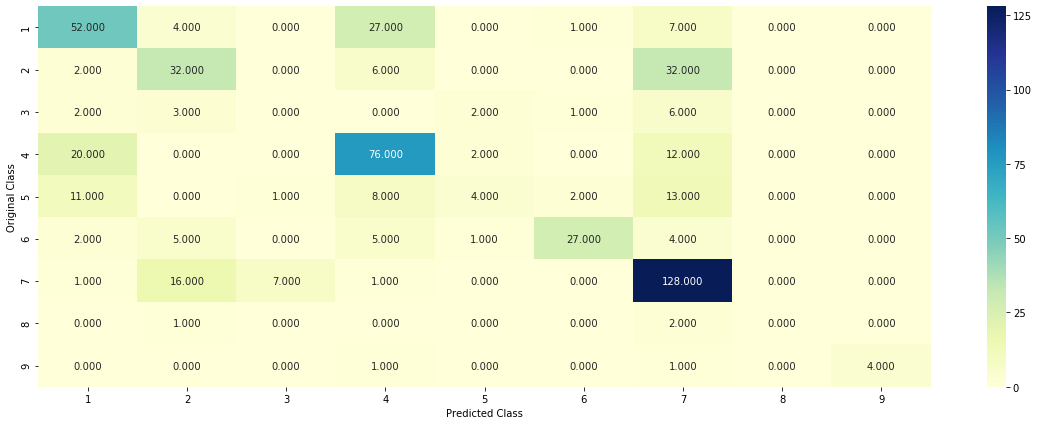

-------------------- Precision matrix (Columm Sum=1) --------------------


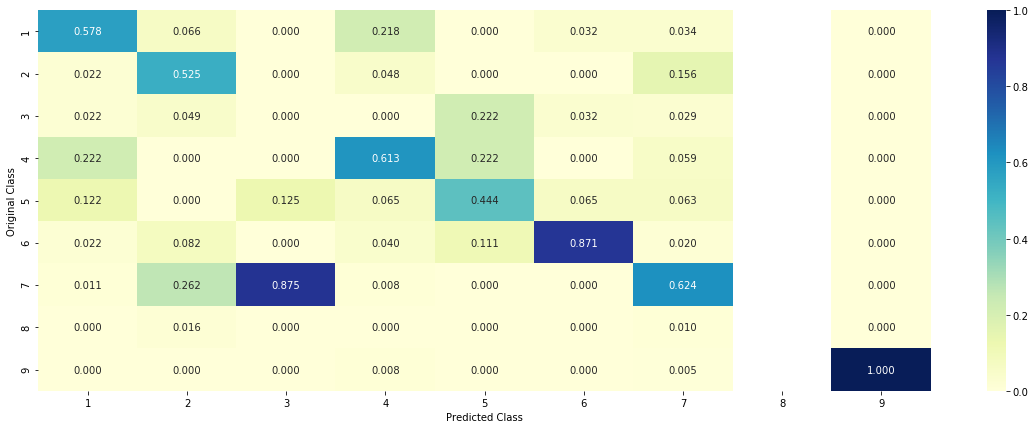

-------------------- Recall matrix (Row sum=1) --------------------


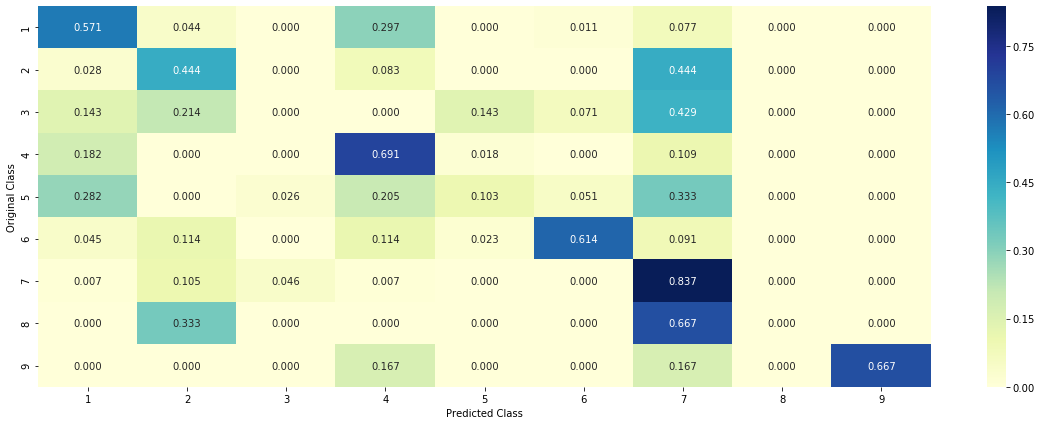

In [87]:
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()b
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [89]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5287 0.076  0.015  0.1944 0.0512 0.0572 0.0694 0.003  0.005 ]]
Actual Class : 1
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [inhibitor] present in test data point [True]
5 Text feature [oncogenic] present in test data point [True]
6 Text feature [tyrosine] present in test data point [True]
7 Text feature [treatment] present in test data point [True]
8 Text feature [activated] present in test data point [True]
9 Text feature [downstream] present in test data point [True]
10 Text feature [phosphorylation] present in test data point [True]
12 Text feature [suppressor] present in test data point [True]
15 Text feature [drug] present in test data point [True]
17 Text feature [inhibited] present in test data point [True]
18 Text feature 

279 Text feature [days] present in test data point [True]
285 Text feature [common] present in test data point [True]
286 Text feature [structural] present in test data point [True]
287 Text feature [hours] present in test data point [True]
288 Text feature [known] present in test data point [True]
289 Text feature [antibodies] present in test data point [True]
290 Text feature [anti] present in test data point [True]
291 Text feature [used] present in test data point [True]
292 Text feature [line] present in test data point [True]
294 Text feature [target] present in test data point [True]
301 Text feature [levels] present in test data point [True]
302 Text feature [higher] present in test data point [True]
305 Text feature [experiments] present in test data point [True]
307 Text feature [13] present in test data point [True]
308 Text feature [site] present in test data point [True]
309 Text feature [also] present in test data point [True]
312 Text feature [well] present in test data 

568 Text feature [although] present in test data point [True]
570 Text feature [occur] present in test data point [True]
571 Text feature [previously] present in test data point [True]
577 Text feature [induced] present in test data point [True]
578 Text feature [fell] present in test data point [True]
581 Text feature [agents] present in test data point [True]
582 Text feature [chemotherapy] present in test data point [True]
583 Text feature [show] present in test data point [True]
585 Text feature [mechanisms] present in test data point [True]
586 Text feature [sequences] present in test data point [True]
587 Text feature [frequency] present in test data point [True]
589 Text feature [table] present in test data point [True]
592 Text feature [35] present in test data point [True]
593 Text feature [18] present in test data point [True]
594 Text feature [identification] present in test data point [True]
595 Text feature [inactivate] present in test data point [True]
596 Text feature [c

832 Text feature [hydrophobic] present in test data point [True]
833 Text feature [partially] present in test data point [True]
836 Text feature [67] present in test data point [True]
840 Text feature [system] present in test data point [True]
841 Text feature [genetic] present in test data point [True]
842 Text feature [apoptosis] present in test data point [True]
843 Text feature [half] present in test data point [True]
845 Text feature [considered] present in test data point [True]
846 Text feature [transfection] present in test data point [True]
848 Text feature [screen] present in test data point [True]
850 Text feature [later] present in test data point [True]
852 Text feature [inhibit] present in test data point [True]
853 Text feature [eight] present in test data point [True]
854 Text feature [distribution] present in test data point [True]
856 Text feature [26] present in test data point [True]
857 Text feature [directly] present in test data point [True]
859 Text feature [51]

In [91]:
test_point_index = 15
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.052  0.2635 0.0166 0.0537 0.0492 0.0481 0.5095 0.003  0.0043]]
Actuall Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [constitutive] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [inhibitor] present in test data point [True]
5 Text feature [oncogenic] present in test data point [True]
6 Text feature [tyrosine] present in test data point [True]
7 Text feature [treatment] present in test data point [True]
8 Text feature [activated] present in test data point [True]
9 Text feature [downstream] present in test data point [True]
10 Text feature [phosphorylation] present in test data point [True]
11 Text feature [receptor] present in test data point [True]
13 Text feature [inhibitors] present in test data point [True]
14 Text f

270 Text feature [21] present in test data point [True]
272 Text feature [loop] present in test data point [True]
274 Text feature [reduced] present in test data point [True]
276 Text feature [14] present in test data point [True]
283 Text feature [western] present in test data point [True]
285 Text feature [common] present in test data point [True]
288 Text feature [known] present in test data point [True]
289 Text feature [antibodies] present in test data point [True]
290 Text feature [anti] present in test data point [True]
291 Text feature [used] present in test data point [True]
292 Text feature [line] present in test data point [True]
294 Text feature [target] present in test data point [True]
297 Text feature [strand] present in test data point [True]
301 Text feature [levels] present in test data point [True]
302 Text feature [higher] present in test data point [True]
305 Text feature [experiments] present in test data point [True]
307 Text feature [13] present in test data poi

566 Text feature [analysis] present in test data point [True]
567 Text feature [suppression] present in test data point [True]
568 Text feature [although] present in test data point [True]
570 Text feature [occur] present in test data point [True]
571 Text feature [previously] present in test data point [True]
574 Text feature [acids] present in test data point [True]
577 Text feature [induced] present in test data point [True]
579 Text feature [exon] present in test data point [True]
581 Text feature [agents] present in test data point [True]
583 Text feature [show] present in test data point [True]
584 Text feature [improved] present in test data point [True]
585 Text feature [mechanisms] present in test data point [True]
587 Text feature [frequency] present in test data point [True]
589 Text feature [table] present in test data point [True]
591 Text feature [specimens] present in test data point [True]
592 Text feature [35] present in test data point [True]
593 Text feature [18] pre

822 Text feature [non] present in test data point [True]
824 Text feature [buffer] present in test data point [True]
825 Text feature [targets] present in test data point [True]
827 Text feature [molecule] present in test data point [True]
837 Text feature [papillary] present in test data point [True]
838 Text feature [thyroid] present in test data point [True]
841 Text feature [genetic] present in test data point [True]
845 Text feature [considered] present in test data point [True]
848 Text feature [screen] present in test data point [True]
853 Text feature [eight] present in test data point [True]
854 Text feature [distribution] present in test data point [True]
855 Text feature [discovery] present in test data point [True]
856 Text feature [26] present in test data point [True]
859 Text feature [51] present in test data point [True]
863 Text feature [76] present in test data point [True]
864 Text feature [32] present in test data point [True]
865 Text feature [consistent] present i

In [93]:
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', 
      alpha[int(best_alpha/4)], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', 
      alpha[int(best_alpha/4)], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', 
      alpha[int(best_alpha/4)], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1855266967685165
for n_estimators = 10 and max depth =  3
Log Loss : 1.9010938678427525
for n_estimators = 10 and max depth =  5
Log Loss : 1.5302721692598613
for n_estimators = 10 and max depth =  10
Log Loss : 2.1547146678012976
for n_estimators = 50 and max depth =  2
Log Loss : 1.6860676000646313
for n_estimators = 50 and max depth =  3
Log Loss : 1.4886297793635241
for n_estimators = 50 and max depth =  5
Log Loss : 1.4171539065905359
for n_estimators = 50 and max depth =  10
Log Loss : 1.7664497977690754
for n_estimators = 100 and max depth =  2
Log Loss : 1.5512688350319863
for n_estimators = 100 and max depth =  3
Log Loss : 1.526330133228856
for n_estimators = 100 and max depth =  5
Log Loss : 1.293317563092307
for n_estimators = 100 and max depth =  10
Log Loss : 1.808932008021683
for n_estimators = 200 and max depth =  2
Log Loss : 1.5669229288951905
for n_estimators = 200 and max depth =  3
Log Loss : 1.4912703411536
for

Log loss : 1.293317563092307
Number of mis-classified points : 0.4567669172932331

-------------------- Confusion matrix --------------------


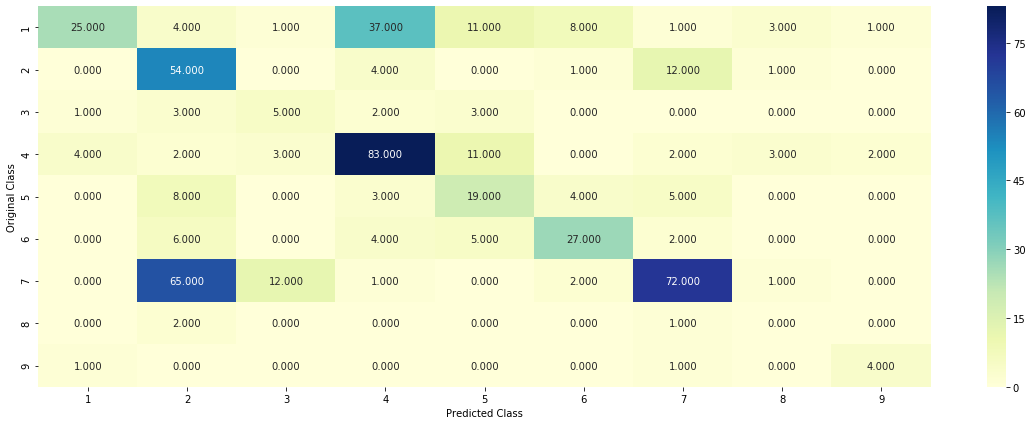

-------------------- Precision matrix (Columm Sum=1) --------------------


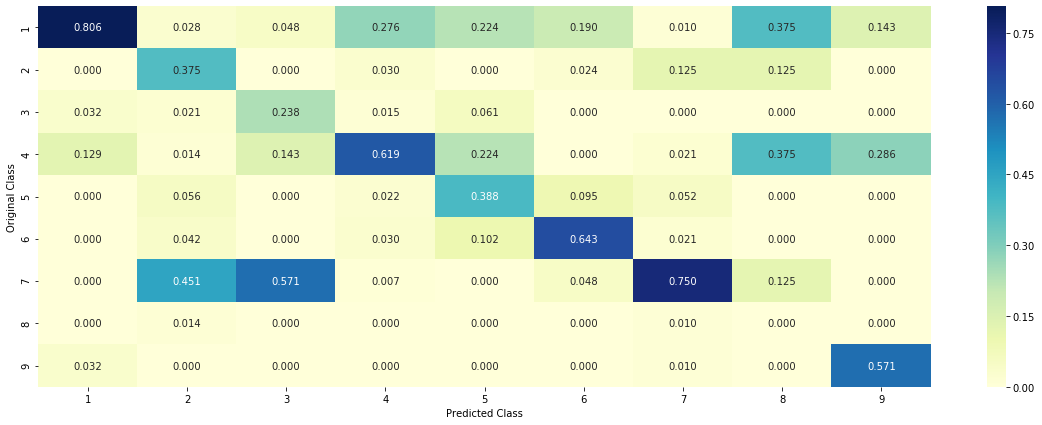

-------------------- Recall matrix (Row sum=1) --------------------


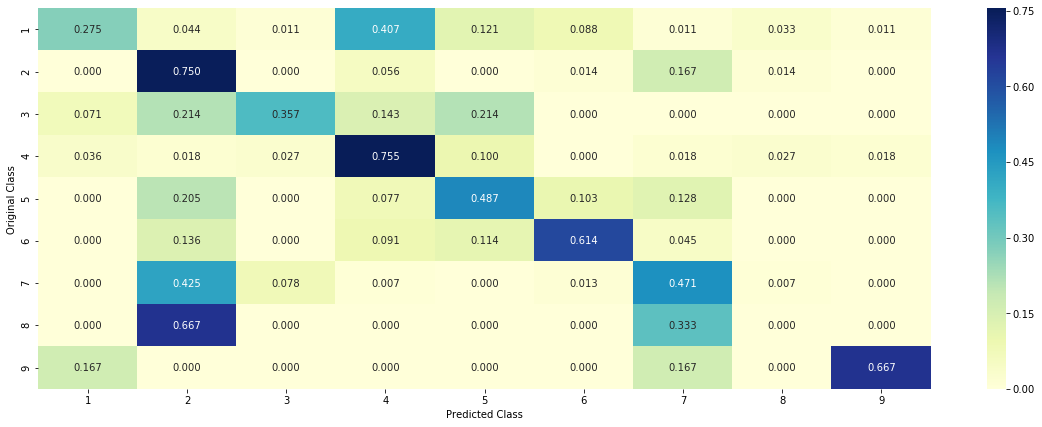

In [94]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [95]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 100
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
# indices = np.argsort(-clf.feature_importances_)
# print("-"*50)
# for i in indices:
#     if i<9:
#         print("Gene is important feature")
#     elif i<18:
#         print("Variation is important feature")
#     else:
#         print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.1201 0.0289 0.1662 0.494  0.04   0.0589 0.009  0.0435 0.0394]]
Actual Class : 4


In [96]:
test_point_index = 31
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
# indices = np.argsort(-clf.feature_importances_)
# print("-"*50)
# for i in indices:
#     if i<9:
#         print("Gene is important feature")
#     elif i<18:
#         print("Variation is important feature")
#     else:
#         print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.0929 0.0338 0.1887 0.5164 0.0356 0.0437 0.0076 0.0393 0.042 ]]
Actual Class : 4


# Stack The Models

In [97]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=1000)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.11
Support vector machines : Log Loss: 1.17
Naive Bayes : Log Loss: 1.22
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.173
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.994
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.406
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.091
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.221
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.565


Log loss (train) on the stacking classifier : 0.6042061255058566
Log loss (CV) on the stacking classifier : 1.09119049360419
Log loss (test) on the stacking classifier : 1.0249739372234026
Number of missclassified point : 0.34135338345864663

-------------------- Confusion matrix --------------------


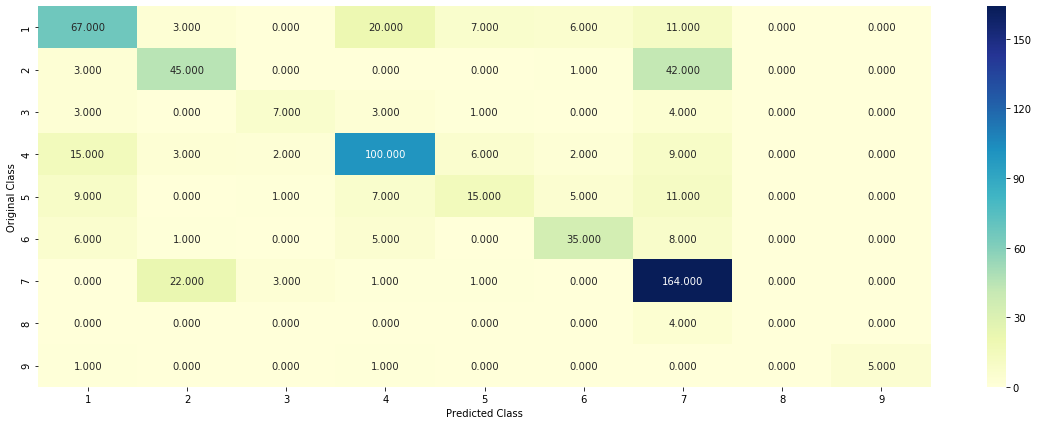

-------------------- Precision matrix (Columm Sum=1) --------------------


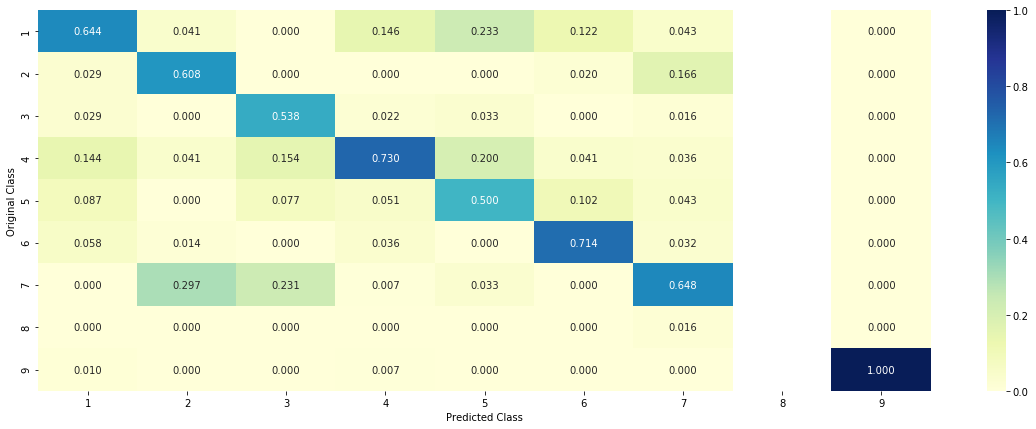

-------------------- Recall matrix (Row sum=1) --------------------


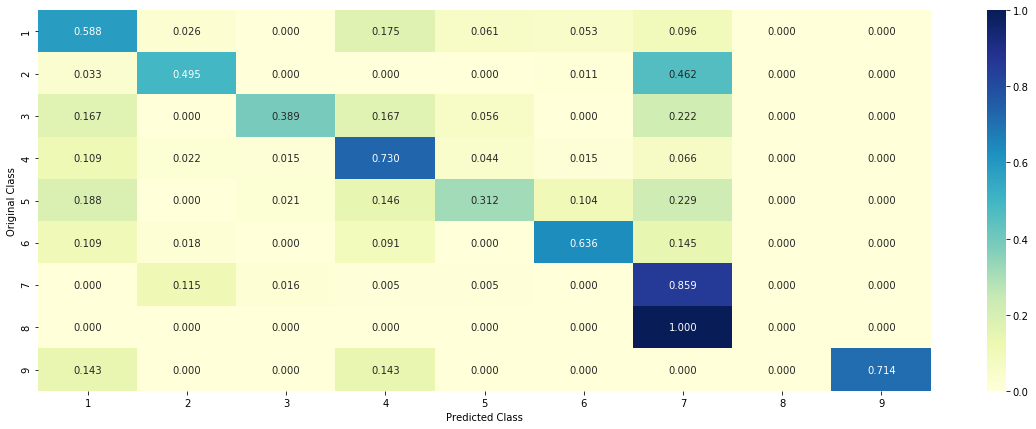

In [98]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

# Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.6893888872250667
Log loss (CV) on the VotingClassifier : 1.0677015127965879
Log loss (test) on the VotingClassifier : 0.9811707230674391
Number of missclassified point : 0.3518796992481203

-------------------- Confusion matrix --------------------


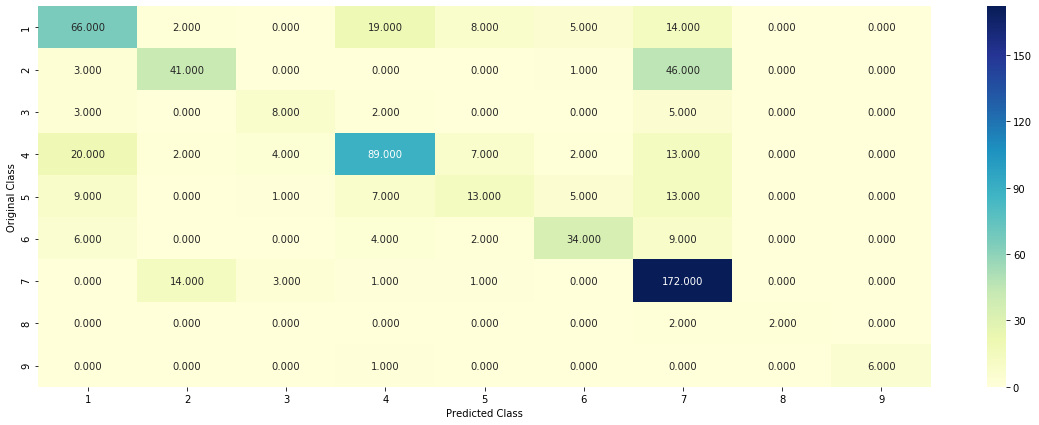

-------------------- Precision matrix (Columm Sum=1) --------------------


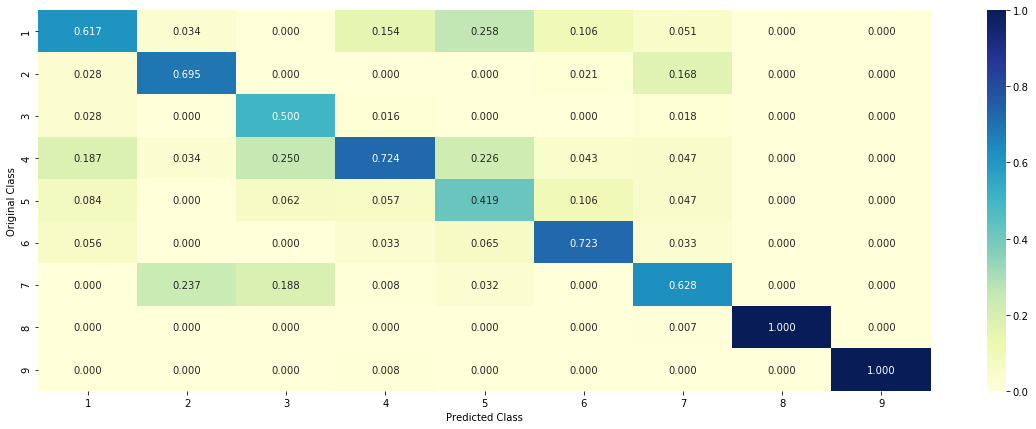

-------------------- Recall matrix (Row sum=1) --------------------


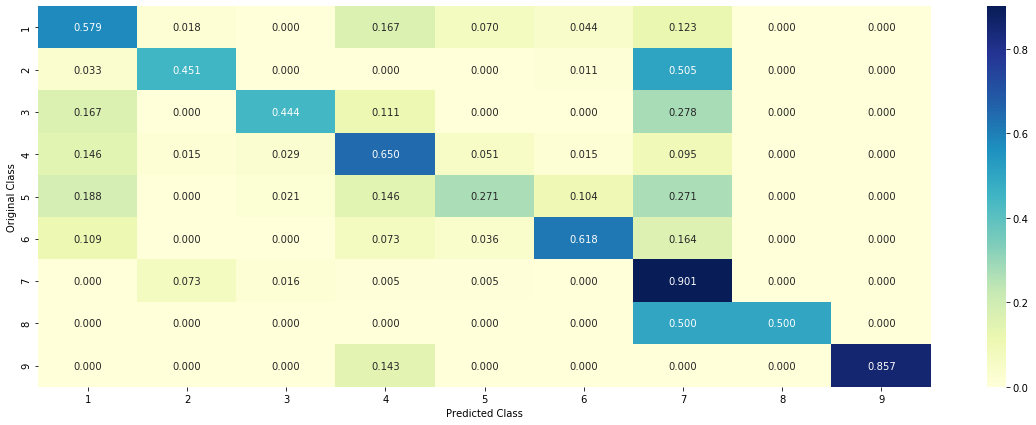

In [99]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# LR with class Balancing On BOW 


In [23]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_test))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [33]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer(ngram_range=(1, 4),min_df=5)
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

# don't forget to normalize every feature
train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)

In [26]:
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))

# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_test))

# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [34]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer(ngram_range=(1, 4),min_df=5)
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])


# don't forget to normalize every feature
train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding, axis=0)
test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding, axis=0)
cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding, axis=0)

In [105]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=5,ngram_range=(1, 4))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 760847


In [106]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [107]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [108]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(y_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [109]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 763150)
(number of data points * number of features) in test data =  (665, 763150)
(number of data points * number of features) in cross validation data = (532, 763150)


In [110]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


for alpha = 1e-06
Log Loss : 1.570454443220152
for alpha = 1e-05
Log Loss : 1.5400714645577374
for alpha = 0.0001
Log Loss : 1.4672563139746189
for alpha = 0.001
Log Loss : 1.2240840129069792
for alpha = 0.01
Log Loss : 1.23034888384657
for alpha = 0.1
Log Loss : 1.261355413871351
for alpha = 1
Log Loss : 1.296571179562698
for alpha = 10
Log Loss : 1.3667555951358168
for alpha = 100
Log Loss : 1.3830018860983684


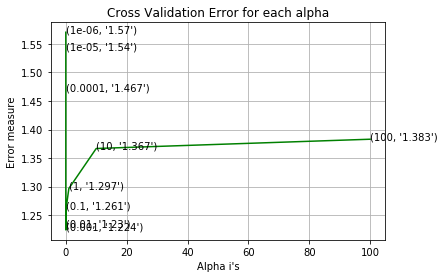

For values of best alpha =  0.001 The train log loss is: 0.7893966095831639
For values of best alpha =  0.001 The cross validation log loss is: 1.2240840129069792
For values of best alpha =  0.001 The test log loss is: 1.1302352381408354


In [113]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2240840129069792
Number of mis-classified points : 0.40601503759398494

-------------------- Confusion matrix --------------------


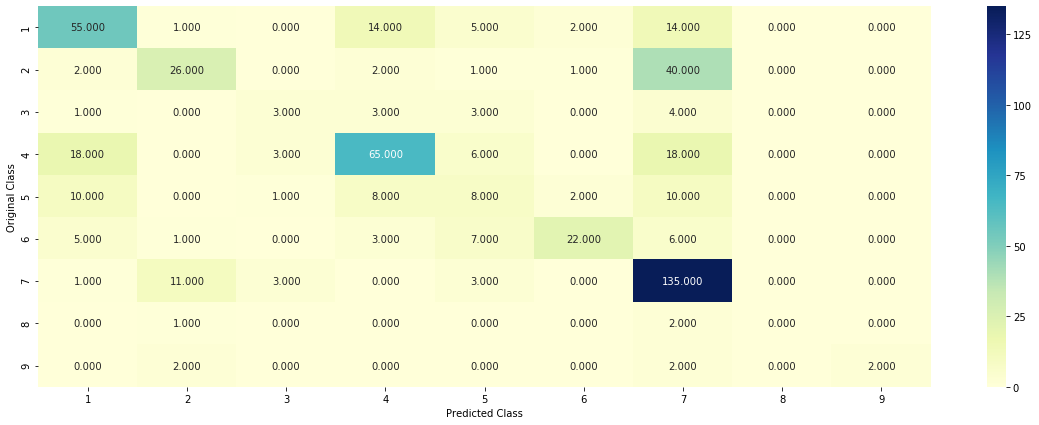

-------------------- Precision matrix (Columm Sum=1) --------------------


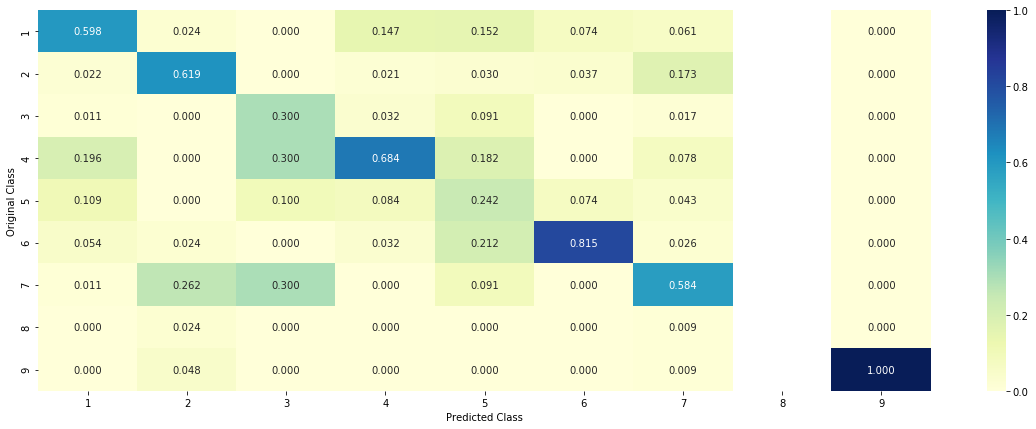

-------------------- Recall matrix (Row sum=1) --------------------


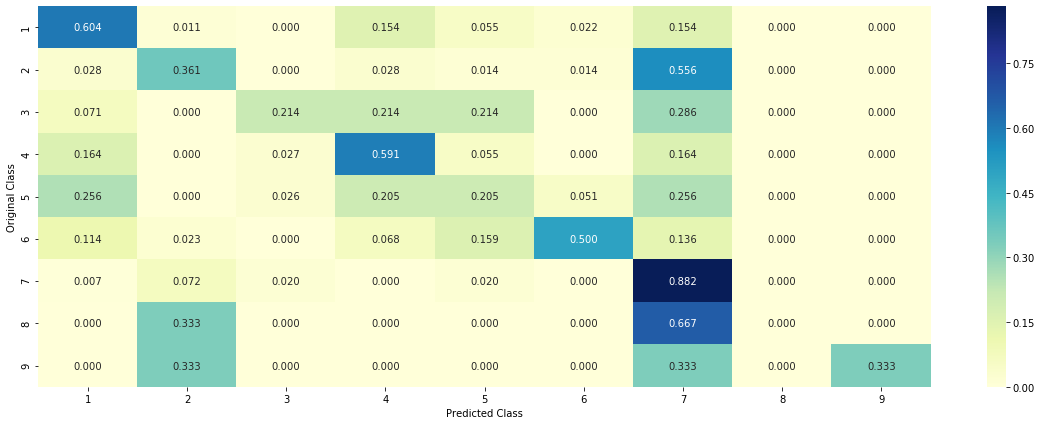

In [112]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

# ApplyingTfidf (1,4)ngrams using LR Model with Class Balancing

In [36]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_test))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [38]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer(ngram_range=(1, 4),min_df=5)
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

# don't forget to normalize every feature
train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)

In [39]:
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))

# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_test))

# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [40]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer(ngram_range=(1, 4),min_df=5)
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])


# don't forget to normalize every feature
train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding, axis=0)
test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding, axis=0)
cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding, axis=0)

In [41]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1, 4),max_features=3000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 3000


In [50]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [51]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [52]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(y_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [53]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3110)
(number of data points * number of features) in test data =  (665, 3110)
(number of data points * number of features) in cross validation data = (532, 3110)


In [54]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


for alpha = 1e-06
Log Loss : 1.1280550427061118
for alpha = 1e-05
Log Loss : 1.1168260289264693
for alpha = 0.0001
Log Loss : 1.1021510973378432
for alpha = 0.001
Log Loss : 1.2062195613530553
for alpha = 0.01
Log Loss : 1.4036264719331117
for alpha = 0.1
Log Loss : 1.8750828231591583
for alpha = 1
Log Loss : 1.8975111023902147
for alpha = 10
Log Loss : 1.898903007968171
for alpha = 100
Log Loss : 1.8990305702120678


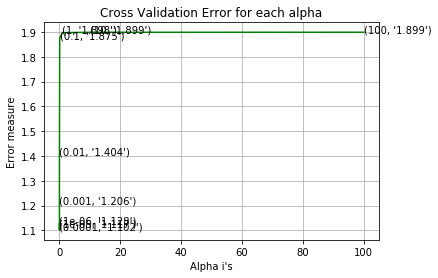

For values of best alpha =  0.0001 The train log loss is: 0.6483471736807301
For values of best alpha =  0.0001 The cross validation log loss is: 1.1021510973378432
For values of best alpha =  0.0001 The test log loss is: 1.0788439583554366


In [55]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', 
      alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1021510973378432
Number of mis-classified points : 0.35150375939849626

-------------------- Confusion matrix --------------------


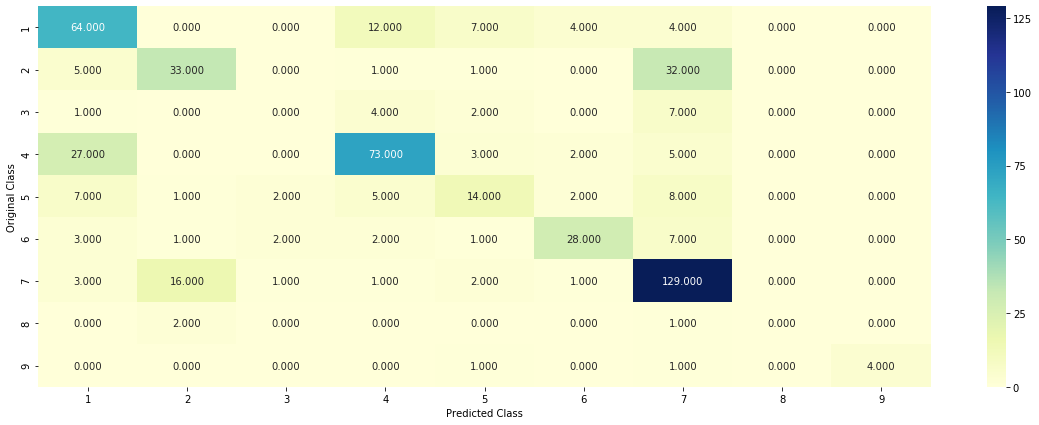

-------------------- Precision matrix (Columm Sum=1) --------------------


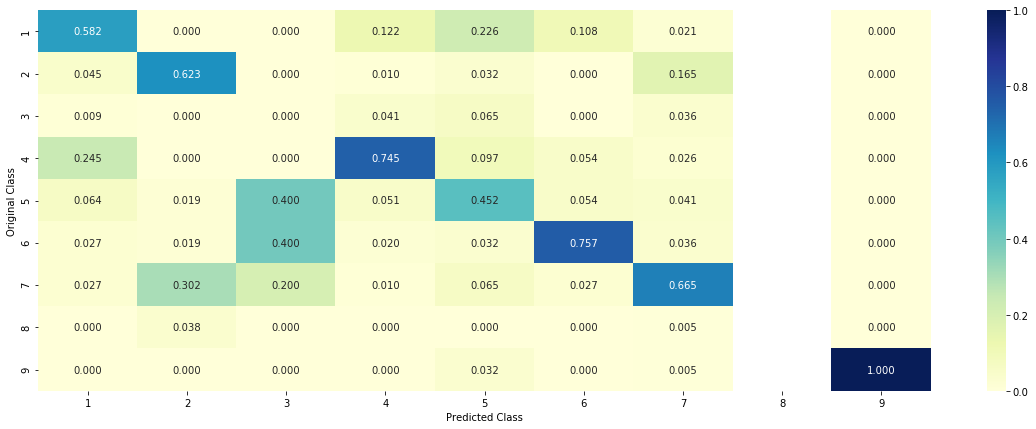

-------------------- Recall matrix (Row sum=1) --------------------


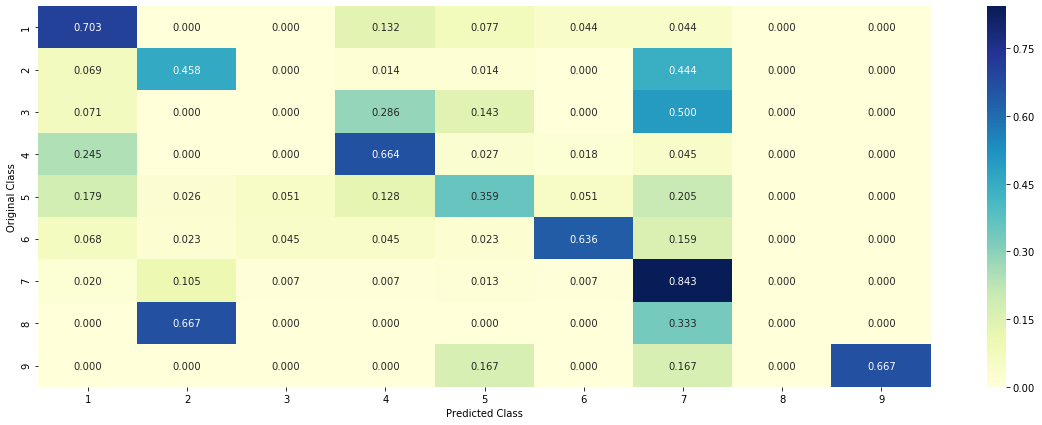

In [60]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

# Pretty Table

In [67]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "*** Model Summary *** [Performance Metric: Log-Loss]"
ptable.field_names=["Model Name","Train","CV","Test","% Misclassified Points"]
ptable.add_row(["Naive Bayes","0.939","1.221","1.189","40"])
ptable.add_row(["KNN","0.897","1.051","1.039","36"])
ptable.add_row(["Logistic Regression With Class balancing","0.535","1.11","0.977","34"])
ptable.add_row(["Logistic Regression Without Class balancing","0.534","1.11","0.985","34"])
ptable.add_row(["Linear SVM","0.582","1.141","1.015","34"])
ptable.add_row(["Random Forest Classifier With One hot Encoding","0.665","1.164","1.128","39"])
ptable.add_row(["Random Forest Classifier With Response Coding","0.059","1.2933","1.251","45"])
ptable.add_row(["Stack Models:LR+NB+SVM","0.604","1.091","1.024","34"])
ptable.add_row(["Maximum Voting classifier","0.689","1.067","0.9811","35"])
ptable.add_row(["Logistic Regression Bow ","0.789","1.22","1.13","40"])
ptable.add_row(["Logistic Regression Tfidf with 3000 features","0.648","1.102","1.07","35"])
print(ptable)
print()

+---------------------------------------------------------------------------------------------------+
|                        *** Model Summary *** [Performance Metric: Log-Loss]                       |
+------------------------------------------------+-------+--------+--------+------------------------+
|                   Model Name                   | Train |   CV   |  Test  | % Misclassified Points |
+------------------------------------------------+-------+--------+--------+------------------------+
|                  Naive Bayes                   | 0.939 | 1.221  | 1.189  |           40           |
|                      KNN                       | 0.897 | 1.051  | 1.039  |           36           |
|    Logistic Regression With Class balancing    | 0.535 |  1.11  | 0.977  |           34           |
|  Logistic Regression Without Class balancing   | 0.534 |  1.11  | 0.985  |           34           |
|                   Linear SVM                   | 0.582 | 1.141  | 1.015  |      